# Combustion Chemistry in Isobaric Reactor: Analyzing the Principal Components of the $R_{H}$ Data Matrix

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import time


### Defining WORKSPACE_PATH

# WORKSPACE_PATH = os.environ['WORKSPACE_PATH']
WORKSPACE_PATH = os.path.join(os.getcwd(), '../../../../../')
ROMNet_fld     = os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/')


### Importing External Libraries

import numpy                             as np
import pandas                            as pd
pd.options.mode.chained_assignment = None  # default='warn'


### Importing Matplotlib and Its Style

import matplotlib.pyplot                 as plt

#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/presentation.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/zoomed.mplstyle'))
plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_2columns.mplstyle'))


from scipy.integrate import solve_ivp
import pyDOE    
from PCAfold         import PCA          as PCAA

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))

3.8.11 (default, Jun 29 2021, 03:17:05) 
[Clang 12.0.0 (clang-1200.0.32.29)]


Missing colon in file PosixPath('/Users/sventur/.matplotlib/stylelib/paper_2columns.mplstyle'), line 1 ('f#### MATPLOTLIBRC FORMAT')


## Defining Input Variables

In [2]:
DataDir            = os.path.join(WORKSPACE_PATH, 'ROMNet/Data/0DReact_Isobaric_500Cases_atol/')
FigDir             = os.path.join(WORKSPACE_PATH, '../Desktop/Paper_Figures_DeepONet_/')

tStratch           = 1.
SOLVER             = 'BDF'

valid_perc         = 20.

FixedMinVal        = 1.e-12

PCA_NAME           = 'T'
VarName            = 'T'
#PCA_NAME           = 'All'

if (PCA_NAME == 'All'):
    n_modesFinal   = 64
    PCAType        = 'All'
else:
    n_modesFinal   = 64
    PCAType        = 'OneByOne'
    
    
ColorVec           = ['#190707', '#dd3232', '#0065a9', '#348a00','#985396','#f68b69']

try:
    os.makedirs(DataDir)
except OSError as e:
    pass
try:
    os.makedirs(DataDir+'/Orig/'+str(PCAType))
except:
    pass

In [3]:
FileName   = DataDir + '/Orig//train/ext/CleanVars.csv'
Vars       = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()[0,:]
NVars      = len(Vars)

iVar       = list(Vars).index(PCA_NAME)

In [4]:
FileName     = DataDir + '/Orig/train/ext/SimIdxs.csv'
Data         = pd.read_csv(FileName, header=0)
SimIdxs      = Data.to_numpy(int)


FileName     = DataDir + '/Orig/train/ext/ICs.csv'
Data         = pd.read_csv(FileName)
ICVecs       = Data.to_numpy()
n_ics         = len(ICVecs)

In [5]:
if (PCA_NAME == 'All'):
    
    Cols   = []
    NewFlg = True
    for iC in range(100):

        Nts                  = SimIdxs[iC,1]-SimIdxs[iC,0]
        NtsNow               = Nts



        FileName             = DataDir+'/Orig/train/ext/y.csv.'+str(iC+1)
        Data                 = pd.read_csv(FileName, header=0)
        DataTemp             = Data[[Vars[iVar] for iVar in range(NVars)]]


        Flg = True
        for iVar in range(NVarsRed):
            if (np.abs( (DataTemp[Vars[iVar]][0] - DataTemp[Vars[iVar]][len(Data)-1])/DataTemp[Vars[iVar]][0] ) < 1.e-4): 
                Flg = False
                break
        
        if Flg:
            DataICTemp  = Data[[Vars[iVar] for iVar in range(NVars)]].iloc[0]
            
            if (NewFlg):
                DataInput        = DataTemp
                DataIC           = DataICTemp
                NewFlg           = False
            else:
                DataInput        = pd.concat([DataInput, DataTemp], axis=1)
                DataIC           = pd.concat([DataIC, DataICTemp], axis=1)
            Cols += [str(iC+1)+'_'+str(iVar+1) for iVar in range(NVars)]
            
        else:
            print('iC ', iC)

    tVec              = Data['t']
    DataInput.columns = Cols
    
    yMat              = DataInput.to_numpy()
    
else:
    
    Cols   = []
    NewFlg = True
    for iC in range(n_ics):

        Nts                  = SimIdxs[iC,1]-SimIdxs[iC,0]
        NtsNow               = Nts



        FileName             = DataDir+'/Orig/train/ext/y.csv.'+str(iC+1)
        Data                 = pd.read_csv(FileName, header=0)
        DataTemp             = Data[Vars[iVar]]

        if (np.abs( (DataTemp[0] - DataTemp[len(Data)-1])/DataTemp[0] ) > 1.e-4):
            DataICTemp  = Data[[Vars[iVar] for iVar in range(NVars)]].iloc[0]
            
            if (NewFlg):
                DataInput        = DataTemp
                DataIC           = DataICTemp
                NewFlg           = False
            else:
                DataInput        = pd.concat([DataInput, DataTemp], axis=1)
                DataIC           = pd.concat([DataIC, DataICTemp], axis=1)
            Cols.append(str(iC+1))

    tVec              = Data['t']
    DataInput.columns = Cols

    yMat              = DataInput.to_numpy()
    
DataIC            = DataIC.T.reset_index(drop=True, inplace=False)

In [6]:
ICs = DataIC.to_numpy()

In [7]:
DataInput

,1,2,3,4,5,6,7,8,9,10,...,491,492,493,494,495,496,497,498,499,500
0,1733.000000,1233.000000,1151.000000,1447.000000,1177.000000,1941.000000,1861.000000,1271.000000,1235.000000,1973.000000,...,1385.000000,1105.000000,1479.000000,1999.000000,1971.000000,1627.000000,1237.000000,1739.000000,1475.000000,1599.000000
1,1732.997488,1232.999995,1150.999999,1446.999899,1176.999998,1940.988789,1860.992553,1270.999992,1234.999995,1972.983377,...,1384.999950,1105.000000,1478.999821,1998.983676,1970.988697,1626.999079,1236.999995,1738.997404,1474.999849,1598.999301
2,1732.997405,1232.999995,1150.999999,1446.999895,1176.999998,1940.988416,1860.992307,1270.999992,1234.999995,1972.982827,...,1384.999948,1105.000000,1478.999815,1998.983132,1970.988320,1626.999049,1236.999995,1738.997319,1474.999844,1598.999278
3,1732.997320,1232.999995,1150.999999,1446.999892,1176.999998,1940.988031,1860.992053,1270.999991,1234.999995,1972.982259,...,1384.999947,1105.000000,1478.999809,1998.982570,1970.987930,1626.999018,1236.999995,1738.997231,1474.999839,1598.999254
4,1732.997232,1232.999995,1150.999999,1446.999888,1176.999998,1940.987634,1860.991791,1270.999991,1234.999995,1972.981671,...,1384.999945,1105.000000,1478.999803,1998.981989,1970.987527,1626.998985,1236.999995,1738.997140,1474.999833,1598.999229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2671.435497,2535.264709,2272.520117,2830.495322,2372.635959,2961.068286,2866.211103,2768.442247,2643.210947,2795.371645,...,2425.372155,2656.171142,2617.942785,2967.204048,2873.886067,2825.612346,2757.171917,2632.188328,2843.484390,2668.082153
496,2671.435497,2535.264709,2272.520117,2830.495322,2372.635959,2961.068286,2866.211103,2768.442247,2643.210947,2795.371645,...,2425.372155,2656.171142,2617.942785,2967.204048,2873.886067,2825.612346,2757.171917,2632.188328,2843.484390,2668.082153
497,2671.435497,2535.264709,2272.520117,2830.495322,2372.635959,2961.068286,2866.211103,2768.442247,2643.210947,2795.371645,...,2425.372155,2656.171142,2617.942785,2967.204048,2873.886067,2825.612346,2757.171917,2632.188328,2843.484390,2668.082153
498,2671.435497,2535.264709,2272.520117,2830.495322,2372.635959,2961.068286,2866.211103,2768.442247,2643.210947,2795.371645,...,2425.372155,2656.171142,2617.942785,2967.204048,2873.886067,2825.612346,2757.171917,2632.188328,2843.484390,2668.082153


In [8]:
# n_modes      = 128
# ScalingVec = ['none', 'auto', 'std', 'pareto', 'vast', 'range', '0to1']
# #'none', '', 'auto', 'std', 'pareto', 'vast', 'range', '0to1', '-1to1', 'level', 'max', 'poisson', 'vast_2', 'vast_3', 'vast_4'

# plt.figure()
# for j, Scaling in enumerate(ScalingVec):

#     pca        = PCAA(yMat, scaling=Scaling, n_components=int(n_modes))
#     C          = pca.X_center
#     D          = pca.X_scale
#     A          = pca.A[:,0:n_modes].T
#     L          = pca.L
#     AT         = A.T

#     plt.plot(L, label=Scaling)
    
# plt.xlim([0., 250])
# plt.ylim([1.e-14, 1.e0])
# plt.yscale('log')
# plt.xlabel('Component Index')
# plt.ylabel('Eigenvalue')
# plt.legend(title='Scaling')

# if (FigDir):
#     plt.savefig(FigDir+'/0DReactor_Eigenvalues_OneByOne_'+Vars[iVar]+'.eps', format='eps', bbox_inches='tight')

In [9]:
# n_modesVec   = np.arange(1,60,5)
# ScalingVec = ['none', 'auto', 'std', 'pareto', 'vast', 'range', '0to1']
# #'none', '', 'auto', 'std', 'pareto', 'vast', 'range', '0to1', '-1to1', 'level', 'max', 'poisson', 'vast_2', 'vast_3', 'vast_4'

# MaxPerc    = np.zeros((len(n_modesVec), len(ScalingVec)))
# MaxSE      = np.zeros((len(n_modesVec), len(ScalingVec)))
# MeanPerc   = np.zeros((len(n_modesVec), len(ScalingVec)))
# MSE        = np.zeros((len(n_modesVec), len(ScalingVec)))
# for i, n_modes in enumerate(n_modesVec):
#     #print('n_modes = ', n_modes)
    
#     for j, Scaling in enumerate(ScalingVec):

#         pca        = PCAA(yMat, scaling=Scaling, n_components=int(n_modes), nocenter=True)
#         C          = pca.X_center
#         D          = pca.X_scale
#         A          = pca.A[:,0:n_modes].T
#         L          = pca.L
#         AT         = A.T

#         yMat_pca   = ((yMat - C)/D).dot(AT)
#         yMat_      = (yMat_pca.dot(A))*D + C
        
#         MaxPerc[i,j]    = np.max(abs((yMat - yMat_)/yMat)*100)
#         MaxSE[i,j]      = np.max((yMat - yMat_)**2)
#         MeanPerc[i,j]   = np.mean(abs((yMat - yMat_)/yMat)*100)
#         MSE[i,j]        = np.mean((yMat - yMat_)**2)

In [10]:
# plt.figure()
# plt.plot(n_modesVec, MaxPerc, label=ScalingVec)
# plt.xlabel('No of Preserved Modes')
# plt.ylabel('Max % Error')
# plt.legend(title='Scaling')
# plt.yscale('log')

# plt.figure()
# plt.plot(n_modesVec, MaxSE, label=ScalingVec)
# plt.xlabel('No of Preserved Modes')
# plt.ylabel('Max Squared Error')
# plt.legend(title='Scaling')
# plt.yscale('log')

# plt.figure()
# plt.plot(n_modesVec, MeanPerc, label=ScalingVec)
# plt.xlabel('No of Preserved Modes')
# plt.ylabel('Mean % Error')
# plt.legend(title='Scaling')
# plt.yscale('log')

# plt.figure()
# plt.plot(n_modesVec, MSE, label=ScalingVec)
# plt.xlabel('No of Preserved Modes')
# plt.ylabel('Mean Squared Error')
# plt.legend(title='Scaling')
# plt.yscale('log')

# if (FigDir):
#     plt.savefig(FigDir+'/0DReact_MSE_'+Vars[iVar]+'.eps', format='eps', bbox_inches='tight')

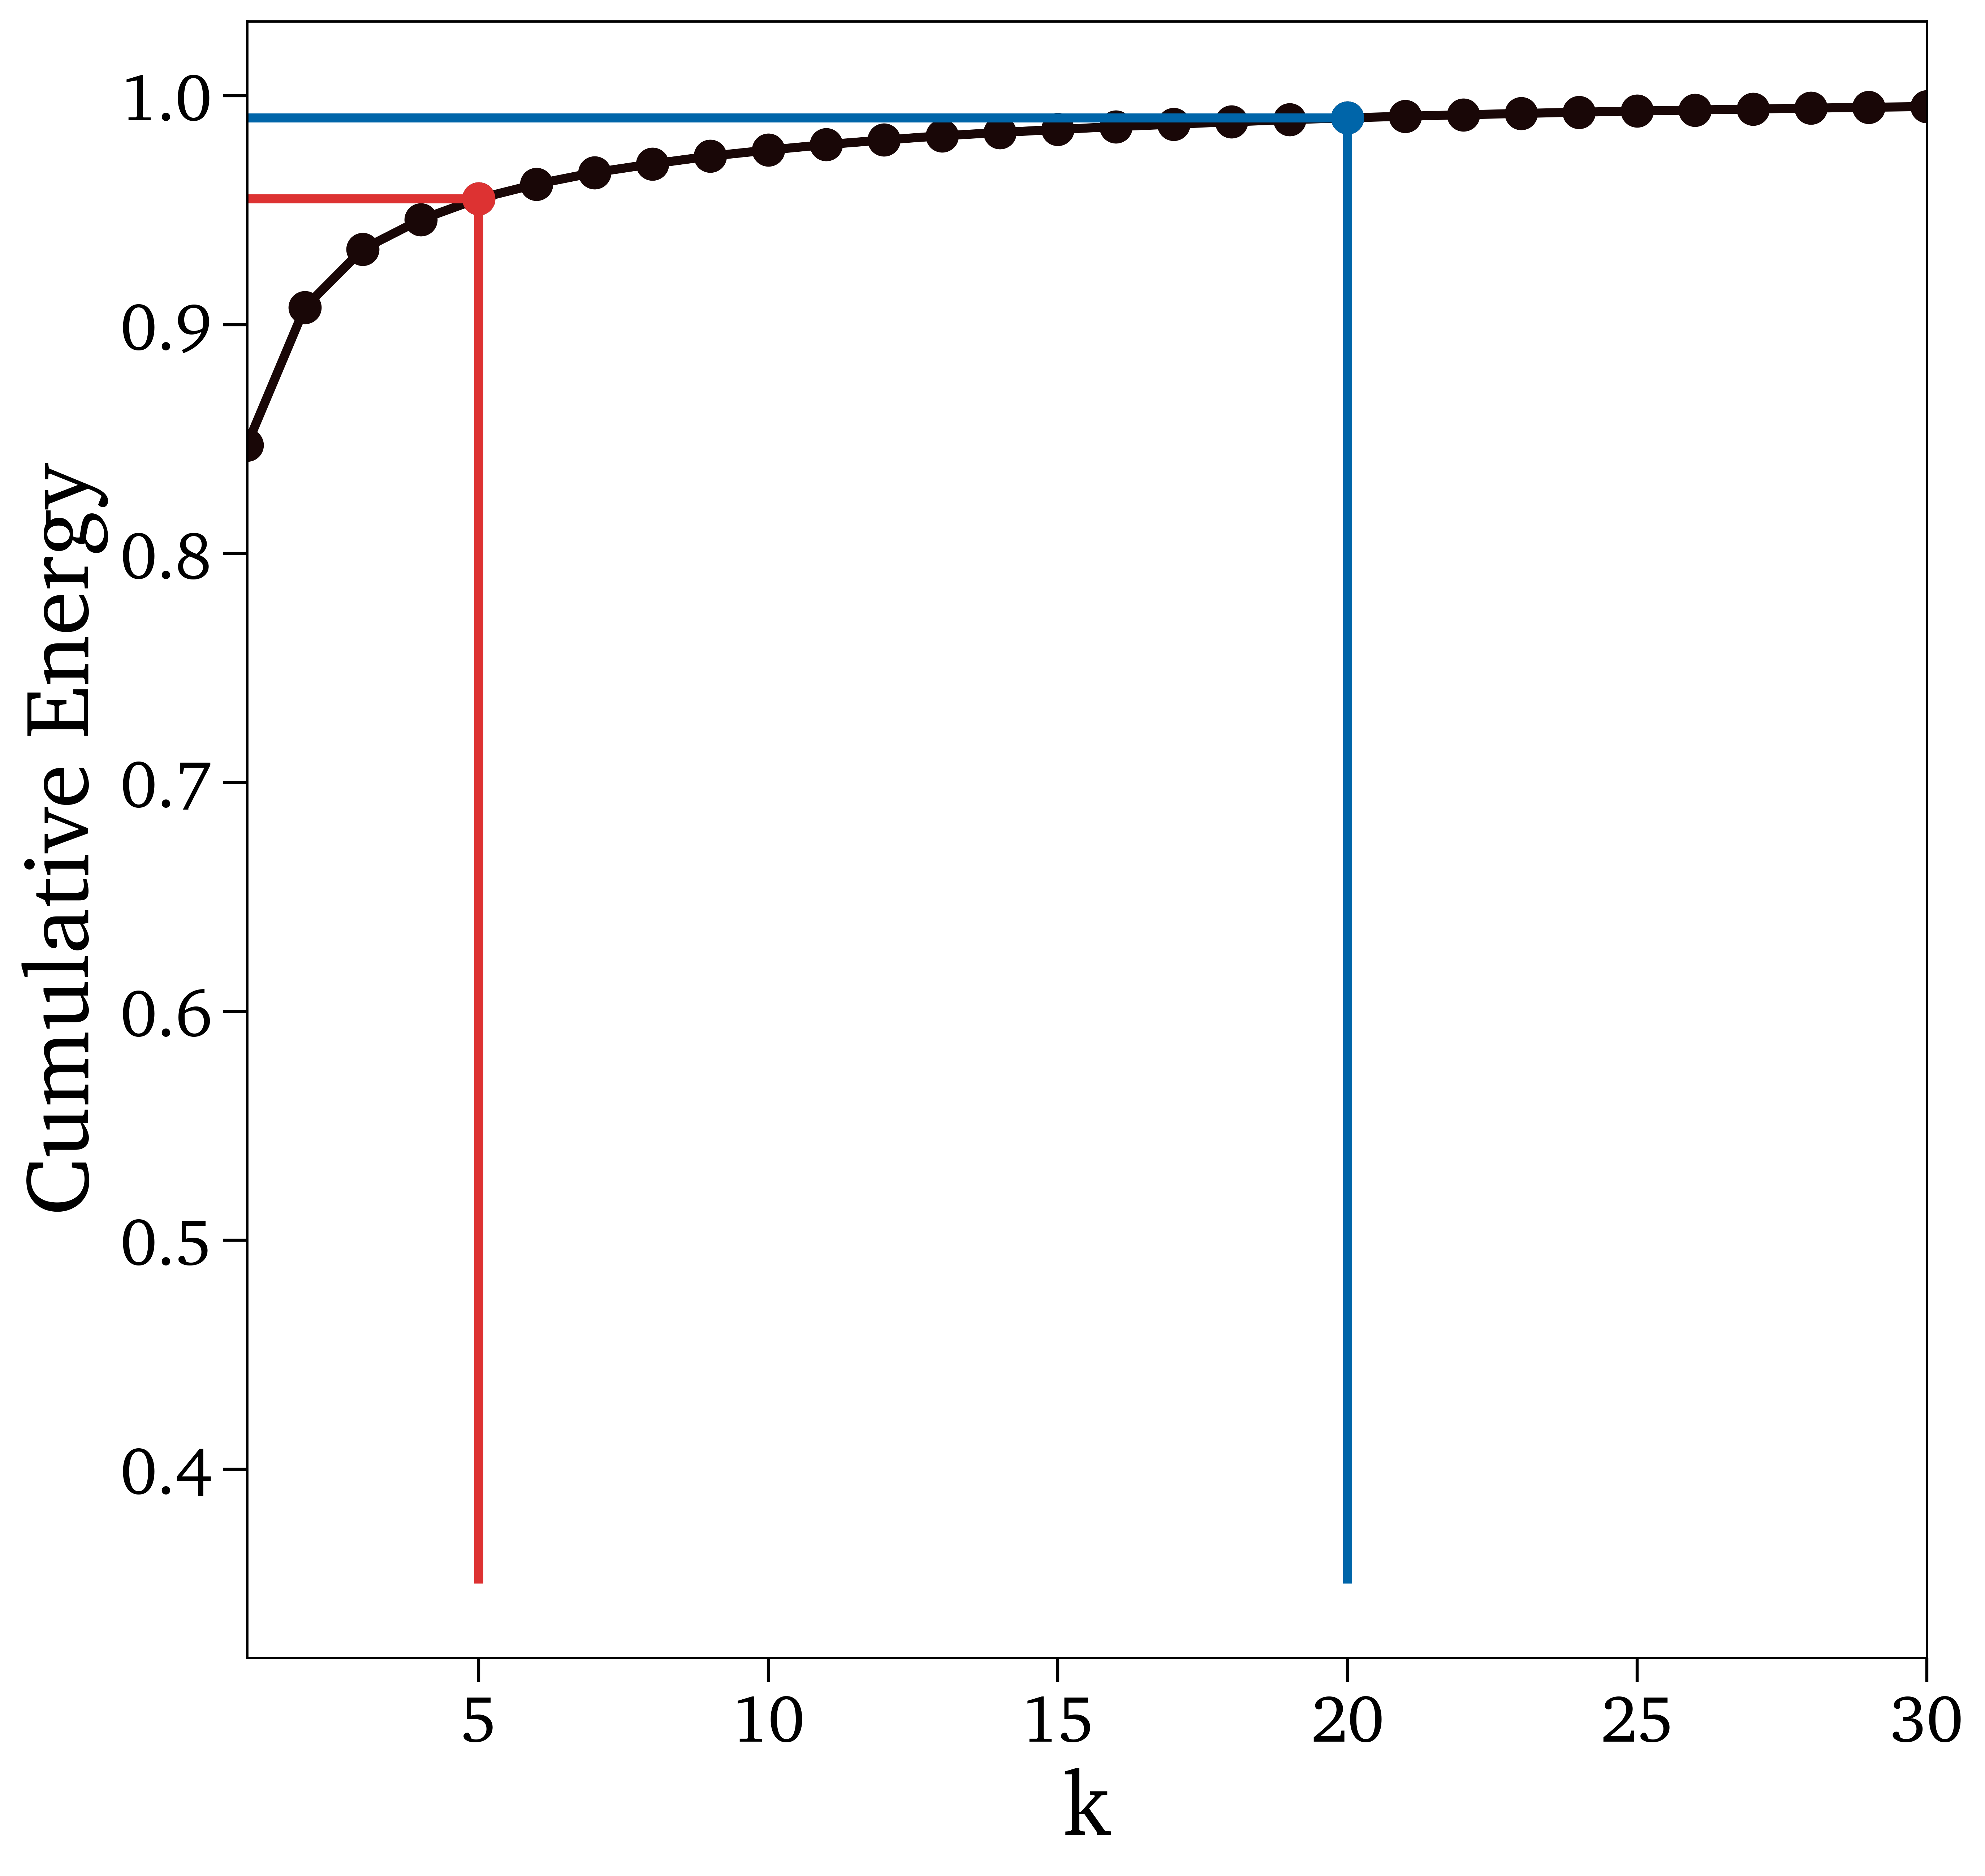

In [11]:
n_modes    = 100
thr1       = 0.95
thr2       = 0.99
thr3       = 0.9999
ScalingVec = ['none']#, 'auto', 'std', 'pareto', 'vast', 'range', '0to1']
             # options: 'none', '', 'auto', 'std', 'pareto', 'vast', 'range', '0to1', '-1to1', 'level', 'max', 'poisson', 'vast_2', 'vast_3', 'vast_4'

fig = plt.figure()
for j, Scaling in enumerate(ScalingVec):

    pca        = PCAA(yMat, scaling='none', n_components=int(n_modes), nocenter=True)
    C          = pca.X_center
    D          = pca.X_scale
    A          = pca.A[:,0:n_modes].T
    L          = pca.L
    LL         = np.maximum(L,0.)
    AT         = A.T
    
    vec        = np.cumsum(np.sqrt(LL))/np.sum(np.sqrt(LL))
    plt.plot(np.arange(len(vec))+1, vec,'-o')


    kk1        = np.sum(np.cumsum(np.sqrt(LL))/np.sum(np.sqrt(LL)) < thr1)+1
    plt.plot(kk1, vec[kk1-1], 'o', c=ColorVec[1])
    plt.hlines(vec[kk1-1], xmin=0, xmax=kk1, color=ColorVec[1])
    plt.vlines(kk1, ymin=0.35, ymax=vec[kk1-1], color=ColorVec[1])
    
    kk2        = np.sum(np.cumsum(np.sqrt(LL))/np.sum(np.sqrt(LL)) < thr2)+1
    plt.plot(kk2, vec[kk2-1], 'o', c=ColorVec[2])
    plt.hlines(vec[kk2-1], xmin=0, xmax=kk2, color=ColorVec[2])
    plt.vlines(kk2, ymin=0.35, ymax=vec[kk2-1], color=ColorVec[2])
    
    kk3        = np.sum(np.cumsum(np.sqrt(LL))/np.sum(np.sqrt(LL)) < thr3)+1

    
plt.xlim([1, kk2+10])
#plt.ylim([0.5, 1.02])
plt.xlabel(r'$k$')
plt.ylabel('Cumulative Energy')
#plt.xticks([1,5,10,15,20])
#plt.yscale('log')

if (FigDir):
    plt.savefig(FigDir+'/0DReact_'+Vars[iVar]+'_CumEnergy.eps', format='eps', bbox_inches='tight')

In [ ]:
### EXPERIMENTING: ROBUST PCA PREPROCESSING

# from __future__ import division, print_function

# import numpy as np

# try:
#     from pylab import plt
# except ImportError:
#     print('Unable to import pylab. R_pca.plot_fit() will not work.')

# try:
#     # Python 2: 'xrange' is the iterative version
#     range = xrange
# except NameError:
#     # Python 3: 'range' is iterative - no need for 'xrange'
#     pass


# class R_pca:

#     def __init__(self, D, mu=None, lmbda=None):
#         self.D = D
#         self.S = np.zeros(self.D.shape)
#         self.Y = np.zeros(self.D.shape)

#         if mu:
#             self.mu = mu
#         else:
#             self.mu = np.prod(self.D.shape) / (4 * np.linalg.norm(self.D, ord=1))

#         self.mu_inv = 1 / self.mu

#         if lmbda:
#             self.lmbda = lmbda
#         else:
#             self.lmbda = 1 / np.sqrt(np.max(self.D.shape))

#     @staticmethod
#     def frobenius_norm(M):
#         return np.linalg.norm(M, ord='fro')

#     @staticmethod
#     def shrink(M, tau):
#         return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))

#     def PCA_threshold(self, M, tau):
#         U, S, V = np.linalg.PCA(M, full_matrices=False)
#         return np.dot(U, np.dot(np.diag(self.shrink(S, tau)), V))

#     def fit(self, tol=None, max_iter=1000, iter_print=100):
#         iter = 0
#         err = np.Inf
#         Sk = self.S
#         Yk = self.Y
#         Lk = np.zeros(self.D.shape)

#         if tol:
#             _tol = tol
#         else:
#             _tol = 1E-7 * self.frobenius_norm(self.D)

#         #this loop implements the principal component pursuit (PCP) algorithm
#         #located in the table on page 29 of https://arxiv.org/pdf/0912.3599.pdf
#         while (err > _tol) and iter < max_iter:
#             Lk = self.PCA_threshold(
#                 self.D - Sk + self.mu_inv * Yk, self.mu_inv)                            #this line implements step 3
#             Sk = self.shrink(
#                 self.D - Lk + (self.mu_inv * Yk), self.mu_inv * self.lmbda)             #this line implements step 4
#             Yk = Yk + self.mu * (self.D - Lk - Sk)                                      #this line implements step 5
#             err = self.frobenius_norm(self.D - Lk - Sk)
#             iter += 1
#             if (iter % iter_print) == 0 or iter == 1 or iter > max_iter or err <= _tol:
#                 print('iteration: {0}, error: {1}'.format(iter, err))

#         self.L = Lk
#         self.S = Sk
#         return Lk, Sk

#     def plot_fit(self, size=None, tol=0.1, axis_on=True):

#         n, d = self.D.shape

#         if size:
#             nrows, ncols = size
#         else:
#             sq = np.ceil(np.sqrt(n))
#             nrows = int(sq)
#             ncols = int(sq)

#         ymin = np.nanmin(self.D)
#         ymax = np.nanmax(self.D)
#         print('ymin: {0}, ymax: {1}'.format(ymin, ymax))

#         numplots = np.min([n, nrows * ncols])
#         plt.figure()

#         for n in range(numplots):
#             plt.subplot(nrows, ncols, n + 1)
#             plt.ylim((ymin - tol, ymax + tol))
#             plt.plot(self.L[n, :] + self.S[n, :], 'r')
#             plt.plot(self.L[n, :], 'b')
#             if not axis_on:
#                 plt.axis('off')

In [ ]:
# LL, SS = R_pca(yMat).fit(max_iter=1500)#tol=5.e-5)

In [ ]:
# iVar = 0

# fig = plt.figure(figsize=(12,8))
# plt.plot(yMat[:,iVar])
# plt.plot(LL[:,iVar])


# fig = plt.figure(figsize=(12,8))
# plt.plot(SS[:,iVar])

In [ ]:
n_modesFinal = 32

pca        = PCAA(yMat, scaling='none', n_components=n_modesFinal, nocenter=True)
C          = pca.X_center
D          = pca.X_scale
A          = pca.A[:,0:n_modesFinal].T
L          = pca.L
AT         = A.T
print('[PCA] Shape of A        = ', A.shape)
print('[PCA] ')

In [ ]:
#yMat_pca    = pca.transform(yMat, nocenter=False)
yMat_pca   = ((yMat - C)/D).dot(AT)

yMat_      = (yMat_pca.dot(A))*D + C
print('[PCA] Shape of yMat_pca = ', yMat_pca.shape)
print('[PCA]  Max % Error = ', np.max(abs((yMat - yMat_)/yMat)*100))
print('[PCA]  Max      SE = ', np.max((yMat - yMat_)**2))
print('[PCA] Mean % Error = ', np.mean(abs((yMat - yMat_)/yMat)*100))
print('[PCA]          MSE = ', np.mean((yMat - yMat_)**2))

In [ ]:
plt.figure()
jCase = 0
for iCase in range(0,500,100):
    if (jCase == 0):
        Label1 = 'ODE'
        Label2 = 'SVD, $N_{\phi}$='+str(n_modesFinal)
    else:
        Label1 = ''
        Label2 = ''

    plt.plot(tVec, yMat[:,iCase],  '-', c=ColorVec[0], label=Label1)
    plt.plot(tVec, yMat_[:,iCase], '--', c=ColorVec[1], label=Label2)
    
    jCase += 1 
    
plt.legend()
plt.xlabel('Time [t]')
if (VarName == 'T'):
    plt.ylabel(r'Temperature [K]')
else:
    plt.ylabel(r'$'+VarName+'$, Mass Fraction')
plt.xscale('log')

if (FigDir):
    plt.savefig(FigDir+'/0DReact_PCA_'+Vars[iVar]+'_Reconstructed_'+str(n_modesFinal)+'.eps', format='eps', bbox_inches='tight')

In [ ]:
n_modesFinal = 64

pca        = PCAA(yMat, scaling='std', n_components=n_modesFinal, nocenter=False)
C          = pca.X_center
D          = pca.X_scale
A          = pca.A[:,0:n_modesFinal].T
L          = pca.L
AT         = A.T
print('[PCA] Shape of A        = ', A.shape)
print('[PCA] ')

In [ ]:
#yMat_pca    = pca.transform(yMat, nocenter=False)
yMat_pca   = ((yMat - C)/D).dot(AT)

yMat_      = (yMat_pca.dot(A))*D + C
print('[PCA] Shape of yMat_pca = ', yMat_pca.shape)
print('[PCA]  Max % Error = ', np.max(abs((yMat - yMat_)/yMat)*100))
print('[PCA]  Max      SE = ', np.max((yMat - yMat_)**2))
print('[PCA] Mean % Error = ', np.mean(abs((yMat - yMat_)/yMat)*100))
print('[PCA]          MSE = ', np.mean((yMat - yMat_)**2))

In [ ]:
iPCVec = [0,31,63]

for iPC in iPCVec:
    
#     Eta_1   = DataIC.to_numpy()[:,0]
#     Eta_2   = DataIC.to_numpy()[:,1]
#     Alpha_1 = A[iPC,:]

#     fig = plt.figure()
#     ax  = fig.add_subplot(projection='3d')
#     ax.scatter(Eta_1, Eta_2, Alpha_1)

    plt.figure()
    plt.plot(tVec, yMat_pca[:,iPC], '-')
    plt.xscale('log')
    plt.xlabel('Time [s]')
    plt.ylabel(r'$\phi_{{'+VarName+'}_{,'+str(iPC+1)+'}}$')
    #plt.xlim([1.e-6,1.e-4])
    
    if (FigDir):
        plt.savefig(FigDir+'/0DReact_PCA_'+Vars[iVar]+'_phi'+str(iPC+1)+'.eps', format='eps', bbox_inches='tight')

In [ ]:
Vars

In [ ]:
# #n_modesFinal = 5

# pca        = PCAA(LL, scaling='pareto', n_components=n_modesFinal, nocenter=False)
# C          = pca.X_center
# D          = pca.X_scale
# A          = pca.A[:,0:n_modesFinal].T
# L          = pca.L
# AT         = A.T
# print('[PCA] Shape of A        = ', A.shape)
# print('[PCA] ')

In [ ]:
# s

In [ ]:
# #yMat_pca    = pca.transform(yMat, nocenter=False)
# yMat_pca   = ((LL - C)/D).dot(AT)

# LL_      = (yMat_pca.dot(A))*D + C
# print('[PCA] Shape of yMat_pca = ', yMat_pca.shape)
# print('[PCA]  Max % Error = ', np.max(abs((LL - LL_)/LL)*100))
# print('[PCA]  Max      SE = ', np.max((LL - LL_)**2))
# print('[PCA] Mean % Error = ', np.mean(abs((LL - LL_)/LL)*100))
# print('[PCA]          MSE = ', np.mean((LL - LL_)**2))

# yMat_    = LL_ + SS
# print('[PCA]  Max % Error = ', np.max(abs((yMat - yMat_)/yMat)*100))
# print('[PCA]  Max      SE = ', np.max((yMat - yMat_)**2))
# print('[PCA] Mean % Error = ', np.mean(abs((yMat - yMat_)/yMat)*100))
# print('[PCA]          MSE = ', np.mean((yMat - yMat_)**2))

In [ ]:
# iVar    = 0

# Eta_1   = DataIC.to_numpy()[:,0]
# Eta_2   = DataIC.to_numpy()[:,1]
# Alpha_1 = A[iVar,:]

# fig = plt.figure(figsize=(12,8))
# ax  = fig.add_subplot(projection='3d')
# ax.scatter(Eta_1, Eta_2, Alpha_1)

# plt.figure(figsize=(10,8))
# plt.plot(tVec, yMat_pca[:,iVar], '-k')
# plt.xscale('log')
# #plt.xlim([1.e-6,1.e-4])

In [ ]:
# iVarVec = np.arange(0,yMat.shape[1])#[10, 20, 30, 40]

# plt.figure(figsize=(10,8))
# for iVar in iVarVec:
#     plt.plot(tVec, yMat[:,iVar], '-k')
#     plt.plot(tVec, yMat_[:,iVar], '-r')
# plt.xscale('log')
# plt.xlim([1.e-6,1.e3])

In [ ]:
# Vars             = ['PCA_'+str(i_mode+1) for i_mode in range(n_modesFinal)]
# Data             = pd.DataFrame(yMat_pca, columns=Vars)
# tVec[tVec == 0.] = FixedMinVal
# Data['t']        = tVec
# Data['log(t)']   = np.log(tVec)
# Data['log10(t)'] = np.log10(tVec)


# Data

In [ ]:
# from sklearn.model_selection import train_test_split

# try:
#     os.makedirs(DataDir+'/'+str(NVarsRed)+'PC/'+str(PCAType)+'/PCA_'+PCA_NAME)
# except:
#     pass
# try:
#     os.makedirs(DataDir+'/'+str(NVarsRed)+'PC/'+str(PCAType)+'/PCA_'+PCA_NAME+'/Trunk/')
# except:
#     pass
# try:
#     os.makedirs(DataDir+'/'+str(NVarsRed)+'PC/'+str(PCAType)+'/PCA_'+PCA_NAME+'/Trunk/train/')
# except:
#     pass
# try:
#     os.makedirs(DataDir+'/'+str(NVarsRed)+'PC/'+str(PCAType)+'/PCA_'+PCA_NAME+'/Trunk/valid/')
# except:
#     pass
# try:
#     os.makedirs(DataDir+'/'+str(NVarsRed)+'PC/'+str(PCAType)+'/PCA_'+PCA_NAME+'/Trunk/test/')
# except:
#     pass

In [ ]:
# data_id    = 'pts'

# DataNoZero           = Data[Data['t'] >= FixedMinVal]
# n_points             = len(DataNoZero)

# idx                  = np.arange(n_points)
# train_idx, valid_idx = train_test_split(idx, test_size=valid_perc/100, random_state=42)

# n_valid              = len(valid_idx)
# n_train              = len(train_idx)


# try:
#     os.makedirs(DataDir+'/'+str(NVarsRed)+'PC/'+str(PCAType)+'/PCA_'+PCA_NAME+'/Trunk/train/'+data_id+'/')
# except:
#     pass
# try:
#     os.makedirs(DataDir+'/'+str(NVarsRed)+'PC/'+str(PCAType)+'/PCA_'+PCA_NAME+'/Trunk/valid/'+data_id+'/')
# except:
#     pass

# DataInput  = DataNoZero[['t', 'log10(t)', 'log(t)'] + Vars]
# DataInput.iloc[train_idx].to_csv(DataDir+'/'+str(NVarsRed)+'PC/'+str(PCAType)+'/PCA_'+PCA_NAME+'/Trunk/train/'+data_id+'/Input.csv', index=False)
# DataInput.iloc[valid_idx].to_csv(DataDir+'/'+str(NVarsRed)+'PC/'+str(PCAType)+'/PCA_'+PCA_NAME+'/Trunk/valid/'+data_id+'/Input.csv', index=False)

# DataOutput = DataNoZero[['t', 'log10(t)', 'log(t)'] + Vars]
# DataOutput.iloc[train_idx].to_csv(DataDir+'/'+str(NVarsRed)+'PC/'+str(PCAType)+'/PCA_'+PCA_NAME+'/Trunk/train/'+data_id+'/Output.csv', index=False)
# DataOutput.iloc[valid_idx].to_csv(DataDir+'/'+str(NVarsRed)+'PC/'+str(PCAType)+'/PCA_'+PCA_NAME+'/Trunk/valid/'+data_id+'/Output.csv', index=False)

In [ ]:
# DataNoZero           = Data
# n_points             = len(DataNoZero)

# n_test               = n_points


# try:
#     os.makedirs(DataDir+'/'+str(NVarsRed)+'PC/'+str(PCAType)+'/PCA_'+PCA_NAME+'/Trunk/test/ext/')
# except:
#     pass

# DataInput  = DataNoZero[['t', 'log10(t)', 'log(t)'] + Vars]
# DataInput.to_csv(DataDir+'/'+str(NVarsRed)+'PC/'+str(PCAType)+'/PCA_'+PCA_NAME+'/Trunk/test/ext/Input.csv', index=False)

# DataOutput = DataNoZero[['t', 'log10(t)', 'log(t)'] + Vars]
# DataOutput.to_csv(DataDir+'/'+str(NVarsRed)+'PC/'+str(PCAType)+'/PCA_'+PCA_NAME+'/Trunk/test/ext/Output.csv', index=False)

In [ ]:
# from sklearn.model_selection import train_test_split

# try:
#     os.makedirs(DataDir+'/'+str(NVarsRed)+'PC/'+str(PCAType)+'/PCA_'+PCA_NAME)
# except:
#     pass
# try:
#     os.makedirs(DataDir+'/'+str(NVarsRed)+'PC/'+str(PCAType)+'/PCA_'+PCA_NAME+'/Branch/')
# except:
#     pass
# try:
#     os.makedirs(DataDir+'/'+str(NVarsRed)+'PC/'+str(PCAType)+'/PCA_'+PCA_NAME+'/Branch/train/')
# except:
#     pass
# try:
#     os.makedirs(DataDir+'/'+str(NVarsRed)+'PC/'+str(PCAType)+'/PCA_'+PCA_NAME+'/Branch/valid/')
# except:
#     pass
# try:
#     os.makedirs(DataDir+'/'+str(NVarsRed)+'PC/'+str(PCAType)+'/PCA_'+PCA_NAME+'/Branch/test/')
# except:
#     pass

In [ ]:
# DataDir+'/'+str(NVarsRed)+'PC/'+str(PCAType)+'/PCA_'+PCA_NAME+'/Branch/train/'

In [ ]:
# data_id    = 'pts'

# n_points             = len(DataIC)

# idx                  = np.arange(n_points)
# train_idx, valid_idx = train_test_split(idx, test_size=valid_perc/100, random_state=42)

# n_valid              = len(valid_idx)
# n_train              = len(train_idx)


# try:
#     os.makedirs(DataDir+'/'+str(NVarsRed)+'PC/'+str(PCAType)+'/PCA_'+PCA_NAME+'/Branch/train/'+data_id+'/')
# except:
#     pass
# try:
#     os.makedirs(DataDir+'/'+str(NVarsRed)+'PC/'+str(PCAType)+'/PCA_'+PCA_NAME+'/Branch/valid/'+data_id+'/')
# except:
#     pass

# DataInput  = DataIC
# DataInput.iloc[train_idx].to_csv(DataDir+'/'+str(NVarsRed)+'PC/'+str(PCAType)+'/PCA_'+PCA_NAME+'/Branch/train/'+data_id+'/Input.csv', index=False)
# DataInput.iloc[valid_idx].to_csv(DataDir+'/'+str(NVarsRed)+'PC/'+str(PCAType)+'/PCA_'+PCA_NAME+'/Branch/valid/'+data_id+'/Input.csv', index=False)

# DataOutput = pd.DataFrame(np.concatenate([A.T, C[...,np.newaxis], D[...,np.newaxis]], axis=1), columns=['PCA_'+str(i+1) for i in range(A.shape[0])]+['C','D'])
# DataOutput.iloc[train_idx].to_csv(DataDir+'/'+str(NVarsRed)+'PC/'+str(PCAType)+'/PCA_'+PCA_NAME+'/Branch/train/'+data_id+'/Output.csv', index=False)
# DataOutput.iloc[valid_idx].to_csv(DataDir+'/'+str(NVarsRed)+'PC/'+str(PCAType)+'/PCA_'+PCA_NAME+'/Branch/valid/'+data_id+'/Output.csv', index=False)

In [ ]:
# n_points             = len(DataIC)

# n_test               = n_points

# try:
#     os.makedirs(DataDir+'/'+str(NVarsRed)+'PC/'+str(PCAType)+'/PCA_'+PCA_NAME+'/Branch/test/ext/')
# except:
#     pass

# DataInput  = DataIC
# DataInput.to_csv(DataDir+'/'+str(NVarsRed)+'PC/'+str(PCAType)+'/PCA_'+PCA_NAME+'/Branch/test/ext/Input.csv', index=False)

# DataOutput = pd.DataFrame(np.concatenate([A.T, C[...,np.newaxis], D[...,np.newaxis]], axis=1), columns=['PCA_'+str(i+1) for i in range(A.shape[0])]+['C','D'])
# DataOutput.to_csv(DataDir+'/'+str(NVarsRed)+'PC/'+str(PCAType)+'/PCA_'+PCA_NAME+'/Branch/test/ext/Output.csv', index=False)

In [ ]:
# NComp = 2

# pca        = PCAA(ICs, scaling='none', n_components=NComp)
# C          = pca.X_center
# D          = pca.X_scale
# A          = pca.A[:,0:NComp].T
# L          = pca.L
# AT         = A.T
# print('[PCA] Shape of A        = ', A.shape)
# print('[PCA] ')

In [ ]:
# #yMat_pca    = pca.transform(yMat, nocenter=False)
# ICs_pca   = ((ICs - C)/D).dot(AT)

# ICs_      = (ICs_pca.dot(A))*D + C
# print('[PCA] Shape of yMat_pca = ', ICs_pca.shape)
# print('[PCA]  Max % Error = ', np.max(abs((ICs - ICs_)/ICs)*100))
# print('[PCA]  Max      SE = ', np.max((ICs - ICs_)**2))
# print('[PCA] Mean % Error = ', np.mean(abs((ICs - ICs_)/ICs)*100))
# print('[PCA]          MSE = ', np.mean((ICs - ICs_)**2))

In [ ]:
# A